# Final Project - Detecting Fraudulent Credit Card Transactions

| Course | Term | Section | Group | Objective | Kaggle URL |
| --- | --- | --- | --- | --- | --- |
| W207 | Fall 2022 | 11 | 2 | Detect fraudulent credit card transactions | IEEE-CIS Fraud Detection ([Link](kaggle.com/competitions/ieee-fraud-detection)) |

**Group Members**
- Naikaj Pandya
- Chase Madson
- Eric Danforth


# I. Setup

### A. Load Libraries

In [1]:
import numpy as np
import pandas as pd
from math import floor
import seaborn as sns
import matplotlib.pyplot as plt
from decimal import Decimal
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale, OneHotEncoder
import tensorflow as tf
from sklearn.metrics import roc_curve, auc

### B. Load Data

In [2]:
# Load Data
train = pd.read_csv('../data/train_transaction.csv')
test = pd.read_csv('../data/test_transaction.csv')
train_identity = pd.read_csv('../data/train_identity.csv')
test_identity = pd.read_csv('../data/test_identity.csv')
sub = pd.read_csv('../data/sample_submission.csv').drop('isFraud', axis=1)

# II. Filter to Latest Transaction by Card

Group the user account (which are truncated to the last 4 digits), the user’s email address (which is just the domain), date the account opened (which we got by subtracting what we thought was the age of the account in days from the transaction date), and billing address (which is encoded). Each of these variables contain null values and we can only get complete sets on about three-quarters of the transactions.

Then we dropped all but the newest record, with the assumption that the latest transaction is the one the cardholder called to report fraud on. Obviously we should be skeptical about this assumption, but that’s the best guess we have to work with. 

In [3]:
def append_time_features(df_tmp):
    df_tmp = (df_tmp
        .assign(
            txn_timestamp = lambda df: 
                pd.to_datetime(
                    arg=df.TransactionDT,
                    unit='s',
                    origin='2018-06-01 00:00:00'
                ).dt.tz_localize(
                    tz='US/Pacific',
                    nonexistent='shift_forward',
                    ambiguous=True),
            txn_date = lambda df: [dt.date() for dt in df.txn_timestamp]
        )
    )
    return df_tmp

# Carry out the appending of new time features on each data set
train = append_time_features(train)
test = append_time_features(test)

In [4]:
train['date_account_opened'] = train.txn_date - pd.to_timedelta(train['D1'].fillna(0), unit = 'D')
test['date_account_opened'] = test.txn_date - pd.to_timedelta(test['D1'].fillna(0), unit = 'D')

c:\Users\chase\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arrays\datetimelike.py:1189: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized.
  warnings.warn(
c:\Users\chase\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arrays\datetimelike.py:1189: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized.
  warnings.warn(


In [5]:
user_composite_key = ['card1', 'addr1', 'date_account_opened', 'P_emaildomain']

In [6]:
train[user_composite_key] = train[user_composite_key].fillna('missing')
test[user_composite_key] = test[user_composite_key].fillna('missing')

In [7]:
train_full = train
train = (train
    .sort_values('TransactionDT')
    .groupby(user_composite_key)
    .last()
    .reset_index()
)
test_full = test
test = (test
    .sort_values('TransactionDT')
    .groupby(user_composite_key)
    .last()
    .reset_index()
)
users = (test
    .sort_values('TransactionDT')
    .groupby(user_composite_key)
    .last()
    .reset_index()
    .filter(regex='|'.join(user_composite_key))
)

# III. Feature Engineering

### A. Custom Groupings for Purchaser and Recipient Domains

To use the purchaser and recipient domain email addresses, we create a highly customized categorical variable called `custom_domain_grouping`. 

This uses a switch statement to condense information about:

1. Drop the domain extensions so "gmail.com" and "gmail" are placed into same group
2. Whether recipient, purchaser, or both email addresses are null
3. Whether the recipient and purchaser domain address matched (e.g., gmail to gmail)
4. If the recipient and purchaser domain addresses do match, what domain is it?

In [8]:
def get_custom_domain_grouping(df_train, df_test):
    """This function is disgusting but gives us good categories from the domain addresses"""

    # Remove the domain extensions on all variables
    df_train['purch_domain_name'] = df_train.P_emaildomain.str.replace('\..*', '', regex=True)
    df_train['recip_domain_name'] = df_train.R_emaildomain.str.replace('\..*', '', regex=True)
    df_test['purch_domain_name'] = df_test.P_emaildomain.str.replace('\..*', '', regex=True)
    df_test['recip_domain_name'] = df_test.R_emaildomain.str.replace('\..*', '', regex=True)

    # Get the list of top 95% of email domains in the _training_ set only 
    top_95pct_purch_domains = (
        df_train.purch_domain_name
        .value_counts(normalize=True)
        .rename_axis('factor_levels')
        .cumsum()
        .reset_index(name='cumsum')
        .query('cumsum<0.95')
        .sort_values('cumsum')
        .factor_levels
        .tolist()   
    )
    
    # This switch statement is based on 
    custom_domain_grouping_train = np.select(
        condlist = [
            # Create a group for null recipients
            df_train.R_emaildomain.isnull(),
            # Create a group for null purchasers (when recipient not null)
            df_train.P_emaildomain.isnull(),
            # Create a group for purchaser domains paired with a distinct recipient domain
            df_train.purch_domain_name != df_train.recip_domain_name,
            # If domains match and in our most common domains 
            df_train.purch_domain_name.isin(top_95pct_purch_domains)
            ], 
        choicelist = [
            'Recipient or Both Blank',
            'Just Purchaser Blank',
            'Purchaser and Recipient Differ',
            'Purchaser and Recipient Same: ' + df_train.purch_domain_name
            ],
        default='Purchaser and Recipient Same: other domain'
    )

    # Do the same as above, but for the test set
    custom_domain_grouping_test = np.select(
        condlist = [
            df_test.R_emaildomain.isnull(),
            df_test.P_emaildomain.isnull(),
            df_test.purch_domain_name != df_test.recip_domain_name,
            df_test.purch_domain_name.isin(top_95pct_purch_domains)
            ], 
        choicelist = [
            'Recipient or Both Blank',
            'Just Purchaser Blank',
            'Purchaser and Recipient Differ',
            'Purchaser and Recipient Same: ' + df_test.purch_domain_name
            ],
        default='Purchaser and Recipient Same: other domain'
    )

    return custom_domain_grouping_train, custom_domain_grouping_test

train['custom_domain_grouping'], test['custom_domain_grouping'] = get_custom_domain_grouping(train, test)
train_full['custom_domain_grouping'], test_full['custom_domain_grouping'] = get_custom_domain_grouping(train_full, test_full)

### B. Whether Currency has More than Two Decimals

We create a new binary variable that indicates whether currency has more than two decimals, which suggests the purchase needed to be converted into USD.

In [9]:
def txn_usd_convert(amt):
    return np.float16(-Decimal(str(amt)).as_tuple().exponent > 2)

train['Transaction_curr_type'] = train['TransactionAmt'].apply(txn_usd_convert)
test['Transaction_curr_type'] = test['TransactionAmt'].apply(txn_usd_convert)

train_full['Transaction_curr_type'] = train_full['TransactionAmt'].apply(txn_usd_convert)
test_full['Transaction_curr_type'] = test_full['TransactionAmt'].apply(txn_usd_convert)

# IV. Data Preparation

### A. Group the Columns

We define a lot of column sets for convenient subsetting features. Breaks down by numeric and categorical, and then type from there. 

In [10]:
# Transaction payment amount in USD
features_num_amt = train[['TransactionAmt']].columns

# Date and time of transactions
features_num_dt = train[['TransactionDT']].columns

# Distance measures between two masked points
features_num_dist = train.filter(regex='^dist').columns

# Various (masked) counts, e.g. how many addresses associated with payment card
features_num_C = train.filter(regex='^C').columns

# Various (masked) timedeltas, e.g. days between previous transactions
features_num_D = train.filter(regex='^D').columns

# Various (masked) Vesta engineered rich features
features_num_V = train.filter(regex='^V').columns

features_num = (
    features_num_amt
    .union(features_num_dt)
    .union(features_num_dist)
    .union(features_num_C)
    .union(features_num_D)
    .union(features_num_V)
)

In [11]:
# Product code for the product associated with the transaction
features_cat_CD = train[['ProductCD']].columns

# Address (unspecified)
features_cat_addr = train.filter(regex='^addr').columns

# Purchaser and recipient email domains
features_cat_domain = train[['custom_domain_grouping']].columns

# Various matches (masked), e.g. names on card and addresses
features_cat_M = train.filter(regex='^M').columns

# New feature - whether the transaction amount had more than 2 decimal places
features_cat_curr_type = train[['Transaction_curr_type']].columns

features_cat = (
    features_cat_CD
    .union(features_cat_domain)
    .union(features_cat_M)
    .union(features_cat_curr_type)
)

In [12]:
# Define the sets of features used, by variable type 
features = features_num.union(features_cat)

# Define our ID column and target
id = train[['TransactionID']].columns
target = train[['isFraud']].columns

# Select relevant columns
train = train[target.union(features)]
test = test[features]
train_full = train_full[target.union(features).union(user_composite_key)]
test_full = test_full[features.union(user_composite_key)]

print(f'We start with {len(features)} available features: {len(features_num)} numeric and {len(features_cat)} categorical.')

We start with 384 available features: 372 numeric and 12 categorical.


### B. Split Data into Train and Validation

In [13]:
# Save 30% of the training data for validation
training, validation = train_test_split(train, test_size=0.3, random_state=1)

# With the remaining 70% in the training set, downsample the majority class
training = (
    training
    .groupby('isFraud')
    .sample(
        n=sum(training.isFraud == 1),
        random_state=1
    )
)

# Separate the features from the label
y_train = training[['isFraud']]
y_val = validation[['isFraud']]
X_train = training[features]
X_val = validation[features]

# Drop unneeded DataFrames
del training, validation

### C. Preprocessing

#### 1. Numeric Values - Replace N/A and Normalize

Apply Min-Max normalization and replace missing values for all numeric features in training, validation, and test sets

In [14]:
def replace_na_and_normalize(df, cols=features_num):
    return (df[cols]
        .apply(lambda var: var.fillna(var.min() - 2))
        .apply(minmax_scale, feature_range=(0,1))
    )

X_train[features_num] = replace_na_and_normalize(X_train)
X_val[features_num] = replace_na_and_normalize(X_val)
test[features_num] = replace_na_and_normalize(test)

#### 2. Categorical Values - Replace N/A and One-Hot Encode

Replace raw categorical features with one-hot encoding values

In [15]:
def get_one_hot_encoding(df, feature):
    # Instantiate the transformer
    ohe = OneHotEncoder()

    # Stack all datasets to get all unique categories observed
    categories = pd.concat([train[[feature]], test[[feature]]])

    # Fit the transformer with the observed classes
    ohe.fit(categories)

    # Create a sparse array with one binary vector per category
    transformed_array = ohe.transform(df[[feature]]).toarray()

    # Turn the transformed array into a DataFrame and assign names
    transformed_ndarray = pd.DataFrame(
        transformed_array,
        columns=ohe.get_feature_names_out(),
        index=df.index
    ).astype(np.float16)

    return transformed_ndarray

In [16]:
def replace_raw_cats_with_one_hots(df, cols=features_cat):
    # Initialize a placeholder list
    tmp_list = []

    # For each variable in our categorical features, get one-hot encoding matrix
    for var in features_cat:
        tmp_list.append(get_one_hot_encoding(df, var))

    # Convert list of DataFrames into one DataFrame of several sparse matrices
    tmp_df = pd.concat(tmp_list, axis=1)

    # Drop the raw categorical variables and replace with sparce matrices
    new_df = pd.concat([df.drop(features_cat, axis=1), tmp_df], axis=1)
    
    return new_df

In [17]:
# Carry out the one-hot encoding functions above for each data set
X_train = replace_raw_cats_with_one_hots(X_train)
X_val = replace_raw_cats_with_one_hots(X_val)
test = replace_raw_cats_with_one_hots(test)

# V. Fitting a Model

### A. Hyperparameters for Manual Tuning

In [18]:
HIDDEN_LAYER_SIZES = [512, 256, 256, 128]
HL_ACTIVATION = 'relu'
LEARNING_RATE = 0.0005
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
LAMBDA = 0.05
DROPOUT_RATE = 0.5
NUM_EPOCHS = 64
BATCH_SIZE = 1024
VALIDATION_SPLIT = 0.1

### B. Define Functions for Building the Model and Testing/Evaluation

In [19]:
def build_model():
  i=0
  tf.keras.backend.clear_session()
  np.random.seed(0)
  tf.random.set_seed(0)
  # INPUT LAYER
  model = tf.keras.Sequential()
  # HIDDEN LAYERS
  for hidden_layer_size in HIDDEN_LAYER_SIZES:
    if i == 0:
      model.add(tf.keras.layers.Dense(
        units=hidden_layer_size, activation=HL_ACTIVATION, name=f'dense_{i}'
      ))
    else:
      model.add(tf.keras.layers.Dense(
        units=hidden_layer_size, activation=HL_ACTIVATION, name=f'dense_{i}',
        kernel_regularizer=tf.keras.regularizers.L2(l2=LAMBDA)
      ))
    model.add(tf.keras.layers.BatchNormalization(name=f'batch_norm_{i}'))
    model.add(tf.keras.layers.Dropout(DROPOUT_RATE, name=f'dropout_{i}'))
    i+=1
  # OUTPUT LAYER
  model.add(tf.keras.layers.Dense(units=1, use_bias=True, activation='sigmoid'))
  model.compile(
    loss='binary_crossentropy', 
    optimizer=OPTIMIZER, 
    metrics=[
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.Precision(name='pre'),
      tf.keras.metrics.Recall(name='rec'),
      ]
  ) 
  return model

In [20]:
def train_and_evaluate(
  df_x_train=X_train,
  df_y_train=y_train,
  df_x_test=X_val,
  df_y_test=y_val
  ):

  # Build the model.
  model = build_model()

  # Train the model.
  print('Training...')

  history = model.fit(
    x=df_x_train,
    y=df_y_train,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT,
    verbose=1
    )
    
  # Retrieve training metrics (after each train epoch) and the final test accuracy
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']
  plt.plot(train_loss, label='train loss')
  plt.plot(val_loss, label='validation loss')
  plt.xticks(range(NUM_EPOCHS))
  plt.xlabel('Train epochs')
  plt.legend()
  plt.show()

  test_metrics = model.evaluate(
    x=df_x_test,
    y=df_y_test,
    verbose=0,
    return_dict=True
    )
  
  return model, test_metrics

### C. Actually Train and Evaluate the Model

Training...
Epoch 1/64
10/10 [==============================] - 2s 62ms/step - loss: 37.1299 - auc: 0.5961 - pre: 0.5101 - rec: 0.5663 - val_loss: 34.3803 - val_auc: 0.0000e+00 - val_pre: 1.0000 - val_rec: 0.3982
Epoch 2/64
10/10 [==============================] - 0s 30ms/step - loss: 32.4626 - auc: 0.6732 - pre: 0.5819 - rec: 0.6144 - val_loss: 30.0758 - val_auc: 0.0000e+00 - val_pre: 1.0000 - val_rec: 0.3049
Epoch 3/64
10/10 [==============================] - 0s 30ms/step - loss: 28.2841 - auc: 0.6870 - pre: 0.6002 - rec: 0.6052 - val_loss: 26.2276 - val_auc: 0.0000e+00 - val_pre: 1.0000 - val_rec: 0.0996
Epoch 4/64
10/10 [==============================] - 0s 31ms/step - loss: 24.5507 - auc: 0.7012 - pre: 0.6110 - rec: 0.6026 - val_loss: 22.8381 - val_auc: 0.0000e+00 - val_pre: 1.0000 - val_rec: 0.0160
Epoch 5/64
10/10 [==============================] - 0s 31ms/step - loss: 21.2702 - auc: 0.7168 - pre: 0.6257 - rec: 0.6070 - val_loss: 19.8680 - val_auc: 0.0000e+00 - val_pre: 1.0000 -

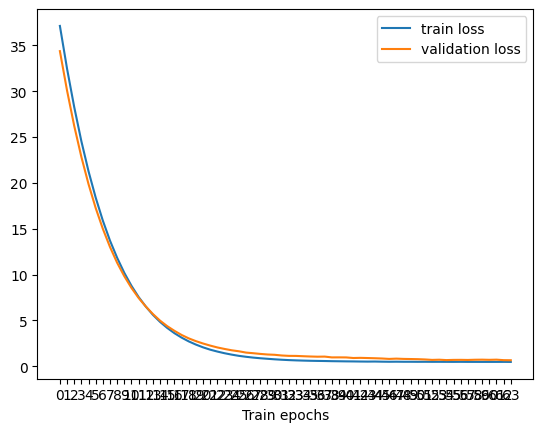

In [21]:
fit, test_metrics = train_and_evaluate()

#### Takeaways

* During training, our validation loss steeply dropped from 30 to below 1 in 16 epochs, then gradually converges to ½ by the 64th. 
* Over those same intervals, the validation recall jumps from less than 1% to 10%, then jumps to converge at 79%. 

In [22]:
fit.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_0 (Dense)             (None, 512)               215040    
                                                                 
 batch_norm_0 (BatchNormaliz  (None, 512)              2048      
 ation)                                                          
                                                                 
 dropout_0 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 batch_norm_1 (BatchNormaliz  (None, 256)              1024      
 ation)                                                          
                                                                 
 dropout_1 (Dropout)         (None, 256)               0

# VI. Evaluating the Model

We will test our model against the 30% of the training data held-out for validation. Since we are doing binary classification, we care about loss (binary cross-entropy), AUC, precision, and recall. We also plot the ROC curve. 

In [23]:
pd.DataFrame({k:f'{v:.1%}' for k, v in test_metrics.items()}, index=[0])

,loss,auc,pre,rec
0,42.0%,85.4%,23.2%,56.2%


2566/2566 [==============================] - 3s 958us/step


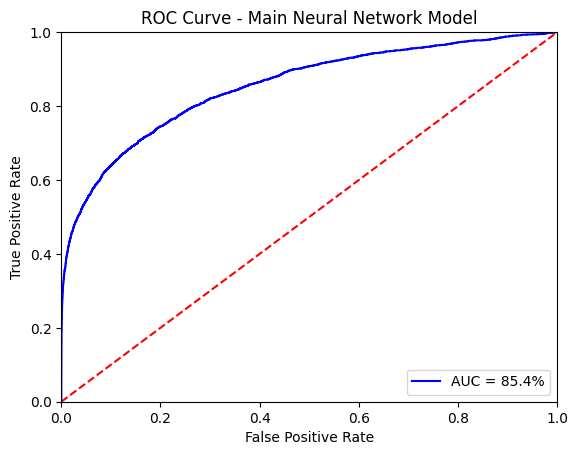

In [24]:
fpr, tpr, threshold = roc_curve(y_val, fit.predict(X_val))

plt.plot(fpr, tpr, 'b', label = f'AUC = {test_metrics["auc"]:.1%}')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve - Main Neural Network Model')
plt.show()

#### Takeaways

* We see a pretty healthy ROC curve with an area-under-the-curve of 88.8%. 

# VII. Outputting Model

Fit our model onto the unlabelled test data, then output as CSV we can upload to Kaggle.

In [25]:
users['predictions'] = fit.predict(test)
sub['isFraud'] = test_full.merge(users, on=user_composite_key, how='left').predictions
sub.to_csv('../data/submissions/lastest_transaction_submission.csv', index=False)

7337/7337 [==============================] - 8s 1ms/step


# VIII. Simple Ensembling Approach

In [26]:
(pd.read_csv('../data/submissions/main_neural_network_submission.csv')
    .merge(sub, on='TransactionID', how='left')
    .assign(isFraud = lambda df: (df.isFraud_x + df.isFraud_y) / 2)
    .drop(['isFraud_x', 'isFraud_y'], axis=1)
).to_csv('../data/submissions/ensemble_submission.csv', index=False)